<a href="https://colab.research.google.com/github/louiezzang/next-diffusion/blob/main/examples/dreambooth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dreambooth Fine-tuning


## Initial setup

In [1]:
#@title Install next-diffusion lib
!rm -rf ./next-diffusion/
!git clone https://github.com/louiezzang/next-diffusion.git
# %cd next-diffusion/
# !pip install .
# %cd ../

Cloning into 'next-diffusion'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 169 (delta 74), reused 108 (delta 35), pack-reused 0
Receiving objects: 100% (169/169), 15.45 MiB | 16.04 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [2]:
#@title Install the required libs
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
# !pip install -U -qq diffusers==0.14.0
!pip install -qq accelerate transformers ftfy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.6 MB/s eta 0:00:00


In [11]:
#@title [Optional] Install xformers for faster and memory efficient training
#@markdown Acknowledgement: The xformers wheel are taken from [TheLastBen/fast-stable-diffusion](https://github.com/TheLastBen/fast-stable-diffusion). Thanks a lot for building these wheels!
%%time

!pip install -U --pre triton

from subprocess import getoutput
from IPython.display import HTML
from IPython.display import clear_output
import time

s = getoutput('nvidia-smi')
if 'T4' in s:
  gpu = 'T4'
elif 'P100' in s:
  gpu = 'P100'
elif 'V100' in s:
  gpu = 'V100'
elif 'A100' in s:
  gpu = 'A100'

while True:
    try: 
        gpu=='T4'or gpu=='P100'or gpu=='V100'or gpu=='A100'
        break
    except:
        pass
    print('[1;31mit seems that your GPU is not supported at the moment')
    time.sleep(5)

print(f"*** GPU type: {gpu}")

# if (gpu=='T4'):
#   %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl
  
# elif (gpu=='P100'):
#   %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/P100/xformers-0.0.13.dev0-py3-none-any.whl

# elif (gpu=='V100'):
#   %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/V100/xformers-0.0.13.dev0-py3-none-any.whl

# elif (gpu=='A100'):
#   %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl

%pip install xformers 
%pip install bitsandbytes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached triton-2.0.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.3 MB)
*** GPU type: T4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 9.2 MB/s eta 0:00:00
CPU times: user 156 ms, sys: 28 ms, total: 184 ms
Wall time: 19.7 s


In [4]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F

import PIL
from diffusers import StableDiffusionPipeline
from PIL import Image


## Dataset

In [5]:
from huggingface_hub import snapshot_download

local_dir = "./dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

'/content/dog'

In [6]:
!ls -la ./dog

total 5476
drwxr-xr-x 2 root root    4096 May 13 16:09 .
drwxr-xr-x 1 root root    4096 May 13 16:09 ..
-rw-r--r-- 1 root root  677407 May 13 16:09 alvan-nee-9M0tSjb-cpA-unsplash.jpeg
-rw-r--r-- 1 root root 1396297 May 13 16:09 alvan-nee-bQaAJCbNq3g-unsplash.jpeg
-rw-r--r-- 1 root root 1186464 May 13 16:09 alvan-nee-brFsZ7qszSY-unsplash.jpeg
-rw-r--r-- 1 root root 1167042 May 13 16:09 alvan-nee-eoqnr8ikwFE-unsplash.jpeg
-rw-r--r-- 1 root root 1163467 May 13 16:09 alvan-nee-Id1DBHv4fbg-unsplash.jpeg


## Training

In [7]:
#@title Setting up accelerator config for the notebook environment.
from accelerate.utils import write_basic_config
write_basic_config()

PosixPath('/root/.cache/huggingface/accelerate/default_config.yaml')

In [2]:
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"
isntance_dir = "dog"
output_dir = "dreambooth_dog"
class_data_dir = "path-to-class-images"

In [ ]:
os.environ["MODEL_NAME"] = pretrained_model_name_or_path
os.environ["INSTANCE_DIR"] = isntance_dir
os.environ["OUTPUT_DIR"] = output_dir
os.environ["CLASS_DIR"] = class_data_dir

### Training on a 12GB GPU:

It is possible to run dreambooth on a 12GB GPU by using the following optimizations:
- gradient checkpointing and the 8-bit optimizer
- xformers
- setting grads to none

In [12]:
!accelerate launch ./next-diffusion/scripts/dreambooth/train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="a photo of sks dog" \
  --class_prompt="a photo of dog" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 --gradient_checkpointing \
  --use_8bit_adam \
  --enable_xformers_memory_efficient_attention \
  --set_grads_to_none \
  --learning_rate=2e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=200 \
  --max_train_steps=800

2023-05-13 16:36:58.018145: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-13 16:37:04.855625: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
05/13/2023 16:37:08 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'dynamic_thresholding_ratio', 'clip_sample_range', 'variance_type', 'sample_max_value', 'prediction_type', 'thresholding'} was not found in config. Values will be initialized to default values.
{'norm_num_groups'} was

## Inference

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

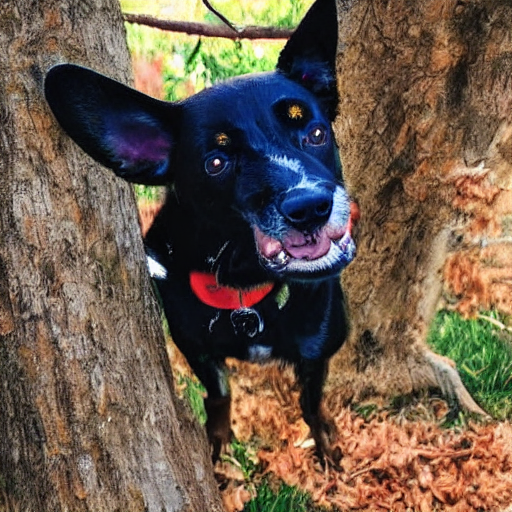

In [3]:
from diffusers import StableDiffusionPipeline
import torch

model_id = output_dir
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

prompt = "A photo of sks dog in a tree"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]

image.save("dog-bucket.png")

image.show()